### Dataset Visualizations

Dataset used: [Metro dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

##### Features:
* holiday: US National Holiday + Minnesota State Holiday
* temp: average Temperature in Kelvin
* rain_1h: mm or Rain
* snow_1h: mm of Snow
* clouds_all: percentage of cloud cover
* weather_main: short text descr. of weather
* weather_description: longer text descr. of weather
* date_time: datetime
* traffic_volume: westbound Traffic Volume (Ground Truth)

In [1]:
# All imports needed
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics

In [2]:
# Read data from file
metro_wmain = pd.read_csv("../data/metro/metro_weather_main.csv")
metro_wmain_s = pd.read_csv("../data/metro/metro_weather_main_s.csv")

metro_wdescr = pd.read_csv("../data/metro/metro_weather_descr.csv")
metro_wdescr_s = pd.read_csv("../data/metro/metro_weather_descr_s.csv")

metro_wall = pd.read_csv("../data/metro/metro_weather_all.csv")
metro_wall_s = pd.read_csv("../data/metro/metro_weather_all_s.csv")


#### Dataset Exploration:

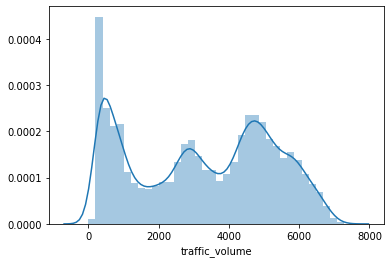

In [3]:
# distribution of target attribute "quality"
sns.distplot(metro_wmain['traffic_volume']) # kde=0 if kernel density estimation is not necessary

# Scatterplot-Matrix visualises correlation of every possible combination of attributes, 
# especially the correlation of the input attributes and the target attribute quality is of importance
# sns.pairplot(metro_wmain)

# heatmap visualises the correlation of each pair of values
# sns.heatmap(metro_wmain.corr())

#### Modeling:

In [4]:
def linear_reg(dataset, name):
    train, test = train_test_split(dataset, test_size=0.2)
    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    model = LinearRegression()
    model.fit(x_train, y_train)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = model.predict(x_test)
    
    return [y_test, y_pred]

In [5]:
def polynomial_reg(dataset, name, degree):
    train, test = train_test_split(dataset, test_size=0.2)
    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(x_train)
    
    model = LinearRegression()
    model.fit(x_poly, y_train)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = model.predict(poly.fit_transform(x_test))
    
    return [y_test, y_pred]

In [6]:
def knn_reg(dataset, name, k_neighbors):
    train, test = train_test_split(dataset, test_size=0.2)
    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    model = neighbors.KNeighborsRegressor(k_neighbors)
    model.fit(x_train, y_train)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = model.predict(x_test)

    return [y_test, y_pred]

In [7]:
def reg_tree(dataset, name):
    train, test = train_test_split(dataset, test_size=0.2)
    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    model = DecisionTreeRegressor(random_state=1)
    model.fit(x_train, y_train)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = model.predict(x_test)

    return [y_test, y_pred]

In [8]:
def get_errs(y):
    # Mean Squared Error
    y_test = y[0]
    y_pred = y[1]
    mse = metrics.mean_squared_error(y_test,y_pred, squared=False)
    rmse = metrics.mean_squared_error(y_test,y_pred)
    r2 = metrics.r2_score(y_test,y_pred) * 100
    
    return mse, rmse, r2

In [9]:
def plot(data, names):
    fig = plt.figure(figsize=[len(data)*4, 4])
    format_string = '{}:\n mse: {:.2f}\n rmse: {:.2f}\n r^2: {:.2f}'
    
    for i, d in enumerate(data):
        plot_nr = i+1
        mse, rmse, r2 = get_errs(d)
        ax = fig.add_subplot(1,len(data),plot_nr)
        ax.scatter(d[0], d[1])
        ax.set_title(format_string.format(names[i], mse, rmse, r2))
        ax.set_aspect('equal')
        plt.xticks(())
        plt.yticks(())
        
    plt.show()        

In [10]:
names = ['weather_main', 'weather_descr', 'weather_all']
datasets = [metro_wmain, metro_wdescr, metro_wall]
datasets = [metro_wmain_s, metro_wdescr_s, metro_wall_s]

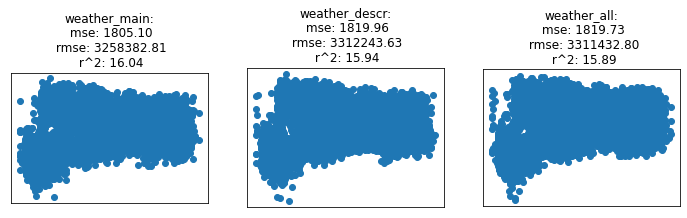

In [11]:
# linear regression

linear = []
for i in range(3):
    linear.append(linear_reg(datasets[i], names[i]))
plot(linear, names)

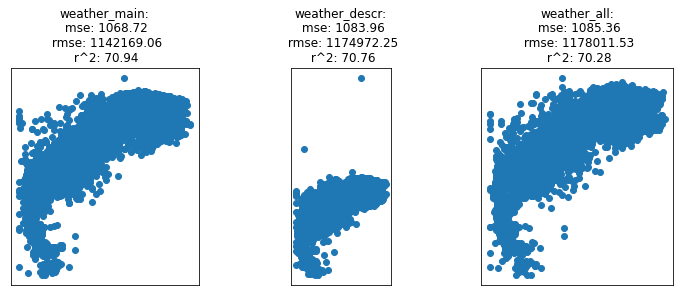

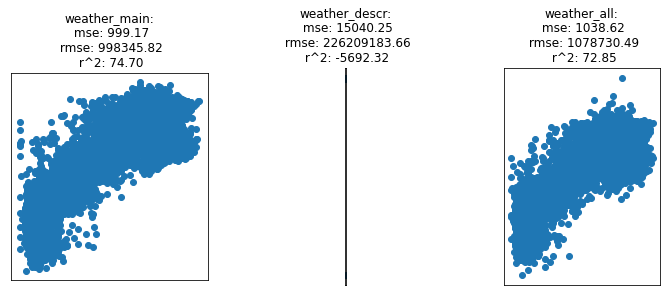

In [12]:
# poly regression

degree = 2
poly = []
for i in range(3):
    poly.append(polynomial_reg(datasets[i], names[i], degree))
plot(poly, names)

degree = 3
poly = []
for i in range(3):
    poly.append(polynomial_reg(datasets[i], names[i], degree))
plot(poly, names)

In [16]:
test = poly[1][0]
pred = poly[1][1]

print('test: min={:.2f}, max={:.2f}'.format(test.min(), test.max()))
print('pred: min={:.2f}, max={:.2f}'.format(pred.min(), pred.max()))

test: min=0.00, max=7260.00
pred: min=-1469209.71, max=6340.10


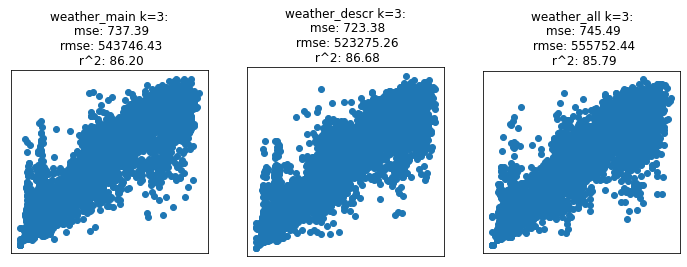

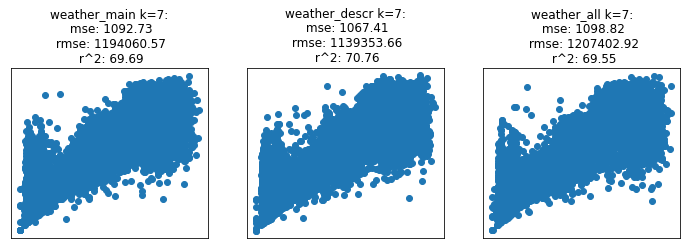

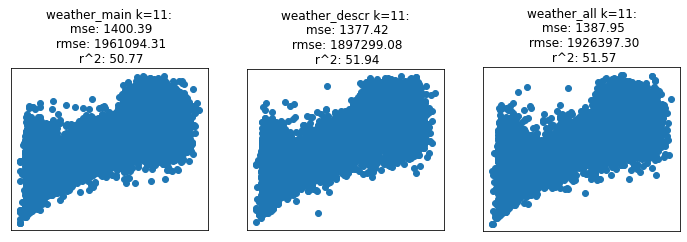

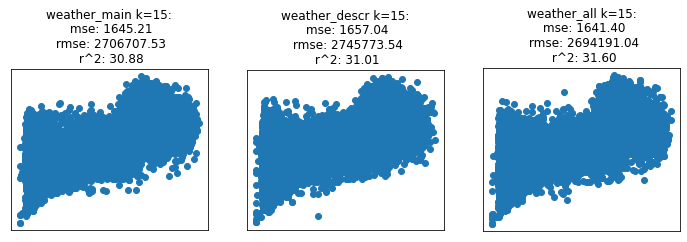

In [14]:
# knn regression

k=3
knn = []
for i in range(3):
    knn.append(knn_reg(datasets[i], names[i], k))
plot(knn, list(map(lambda x: '{} k={}'.format(x,k), names)))

k=7
knn = []
for i in range(3):
    knn.append(knn_reg(datasets[i], names[i], k))
plot(knn, list(map(lambda x: '{} k={}'.format(x,k), names)))

k=11
knn = []
for i in range(3):
    knn.append(knn_reg(datasets[i], names[i], k))
plot(knn, list(map(lambda x: '{} k={}'.format(x,k), names)))

k=15
knn = []
for i in range(3):
    knn.append(knn_reg(datasets[i], names[i], k))
plot(knn, list(map(lambda x: '{} k={}'.format(x,k), names)))

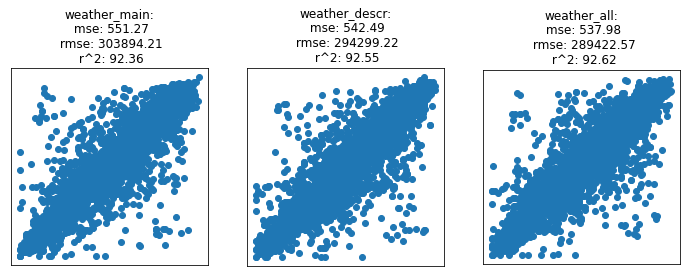

In [15]:
# regression trees

tree = []
for i in range(3):
    tree.append(reg_tree(datasets[i], names[i]))
plot(tree, names)